## Introduction

In this notebook, wordclouds are created using BM25, with the inaugural speeches by the USA presidents as the dataset.\
First, the speeches are extracted from text files, then BM25 is calculated for each year.
Wordclouds are created based on BM25.

## Libraries

In [23]:
import glob
import nltk
import re

import math
from statistics import mean

import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud

## Reading Files

In [3]:
files = glob.glob('../inaugural/*.txt')

len(files)

59

There are 59 speech texts in total.

In [4]:
with open(files[0]) as f:
    lines = f.readlines()

lines

['The Price of Peace\n',
 'Mr. Chairman, Mr. Vice President, Mr. Chief Justice, Mr. Speaker, members of my family and friends, my countrymen, and the friends of my country, wherever they may be, we meet again, as upon a like moment four years ago, and again you have witnessed my solemn oath of service to you.\n',
 'I, too, am a witness, today testifying in your name to the principles and purposes to which we, as a people, are pledged.\n',
 '\n',
 'Before all else, we seek, upon our common labor as a nation, the blessings of Almighty God. And the hopes in our hearts fashion the deepest prayers of our whole people.\n',
 '\n',
 'May we pursue the right -- without self-righteousness.\n',
 '\n',
 'May we know unity -- without conformity.\n',
 '\n',
 'May we grow in strength -- without pride in self.\n',
 '\n',
 'May we, in our dealings with all peoples of the earth, ever speak truth and serve justice.\n',
 '\n',
 'And so shall America -- in the sight of all men of good will -- prove true to

## Tokenisation, Stemming, and Counting Words

In [7]:
stop_words = nltk.corpus.stopwords.words('english')

porter = nltk.stem.PorterStemmer()

In [17]:
cnt_all = pd.DataFrame()

for file in files:
    # Reading each text file
    with open(file) as f:
        lines = f.readlines()

    words_all = []
    
    for line in lines:
        line = re.sub('\-', ' ', line)            # Replace '-' with space
        line = re.sub('[^a-zA-Z ]', '', line)     # Remove anything but letters and numbers
        line = line.lower()                       # Lower words
        line = nltk.tokenize.word_tokenize(line)  # Tokenise each line
    
        words = []
        for word in line:
            word = porter.stem(word)              # Stem words
            if word not in stop_words:            # Remove stopwords
                words.append(word)
    
        words_all.extend(words)

    cnt = pd.Series(words_all).value_counts()     # Count each word

    cnt_all = pd.concat([cnt_all, cnt], axis = 1) # 
    cnt_all.rename(columns = {cnt_all.columns[-1]: file[13:-4]},
                   inplace = True)

In [19]:
cnt_all.shape

(5411, 59)

In [18]:
cnt_all.head()

,1957-Eisenhower,1881-Garfield,1905-Roosevelt,1985-Reagan,1913-Wilson,1793-Washington,1885-Cleveland,1789-Washington,1845-Polk,1925-Coolidge,...,1893-Cleveland,1989-Bush,1897-McKinley,1797-Adams,1833-Jackson,1965-Johnson,1997-Clinton,1821-Monroe,1825-Adams,1865-Lincoln
nation,18.0,21.0,9.0,11.0,7.0,NaN,7.0,4.0,13.0,21.0,...,8.0,12.0,7.0,24.0,2.0,13.0,15.0,14.0,21.0,4.0
world,16.0,3.0,3.0,16.0,2.0,NaN,1.0,1.0,5.0,13.0,...,NaN,10.0,6.0,3.0,2.0,7.0,15.0,2.0,1.0,1.0
peopl,15.0,21.0,6.0,17.0,2.0,1.0,18.0,4.0,16.0,16.0,...,22.0,7.0,25.0,20.0,9.0,9.0,11.0,11.0,7.0,NaN
may,15.0,7.0,NaN,2.0,3.0,1.0,4.0,6.0,13.0,8.0,...,4.0,2.0,11.0,13.0,4.0,1.0,4.0,15.0,3.0,3.0
thi,15.0,19.0,6.0,17.0,6.0,2.0,11.0,10.0,14.0,17.0,...,12.0,19.0,21.0,18.0,4.0,21.0,15.0,30.0,25.0,7.0


## Calculating BM25

Formula for BM25
##### $score(t_i, d_j) = idf(t_i)\cdot\frac{tf(t_i, d_j)\cdot(k_1+1)}{tf(t_i,d_j)+k_1\cdot(1-b+b*\frac{dl(d_j)}{avgdl})}$

$where...$\
$\space\space tf =  \frac{f(t_i,d_j)}{\sum{t_k\in d_j f(t_k,d_j)}{}} = \frac{\text{the count of term } t_1 \text{ in document } d_j}{\text{the count of all words in } \text{document } d_j}$\
$\space\space idf = log(\frac{N}{df(t_i)}) = log(\frac{\text{the number of documents}}{\text{the nunber of documents with term }t_i})$\
$\space\space k_1 = 1.2, or\space 2.0\space（Parameter１）$\
$\space\space b   = 0.75\space（Parameter２）$\
$\space\space dl = \text{the number of words in } \text{document } d_j$\
$\space\space avgdl = \text{the average number of words for all documents}$

In [20]:
cnt_all = cnt_all.fillna(0)

In [21]:
dl = [cnt_all[column].sum() for column in cnt_all.columns]
dl_avg = mean(dl)

k1 = 1.2
b  = 0.75
N  = len(cnt_all.columns)

for i in range(len(cnt_all)):
    n    = sum([freq != 0 for freq in cnt_all.iloc[i, :]])
    tf   = cnt_all.iloc[i, :] / dl
    idf  = math.log(N / n)                                                     # For words that are used in all years, the score becomes '0'
    
    bm25 = idf * ((tf * (k1 + 1)) / (tf + k1 * (1 - b + b * (dl / dl_avg))))   # For words that are used in all years, the score becomes '0'
    
    cnt_all.iloc[i, :] = bm25

cnt_all.head()

,1957-Eisenhower,1881-Garfield,1905-Roosevelt,1985-Reagan,1913-Wilson,1793-Washington,1885-Cleveland,1789-Washington,1845-Polk,1925-Coolidge,...,1893-Cleveland,1989-Bush,1897-McKinley,1797-Adams,1833-Jackson,1965-Johnson,1997-Clinton,1821-Monroe,1825-Adams,1865-Lincoln
nation,0.000823,0.000355,0.001028,0.000228,0.000329,0.000000,0.000331,0.000266,0.000098,0.000218,...,0.000270,0.000334,0.000071,0.000667,0.000177,0.000734,0.000403,0.000124,0.000386,0.000691
world,0.003797,0.000265,0.001807,0.001714,0.000491,0.000000,0.000247,0.000347,0.000196,0.000701,...,0.000000,0.001443,0.000314,0.000438,0.000917,0.002065,0.002089,0.000092,0.000096,0.000908
peopl,0.001388,0.000717,0.001395,0.000709,0.000191,0.003138,0.001696,0.000537,0.000243,0.000336,...,0.001482,0.000394,0.000508,0.001124,0.001582,0.001031,0.000598,0.000197,0.000262,0.000000
may,0.003564,0.000618,0.000000,0.000216,0.000735,0.008059,0.000985,0.002062,0.000508,0.000432,...,0.000703,0.000290,0.000576,0.001886,0.001826,0.000298,0.000561,0.000690,0.000288,0.002699
thi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
cnt_all.sort_values('2021-Biden', ascending = False)[['2021-Biden']].head()

,2021-Biden
stori,0.027798
viru,0.022107
democraci,0.017624
america,0.016423
cri,0.013770


The table above shows the top 5 words in terms of BM25 in the 2021's Biden speech.

## Wordcloud

In [24]:
def plt_wordcloud(cnt_all, year, cnt):
    BM25_dict = cnt_all.sort_values(year, ascending = False)[[year]].head(cnt).to_dict()[year]
    
    wordcloud = WordCloud(background_color = 'white',
                          max_words = 125,
                          width = 1000,
                          height = 600,
                          ).fit_words(BM25_dict)
    
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

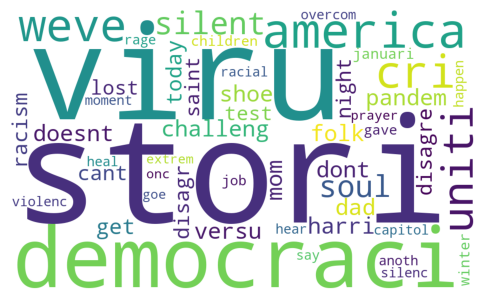

In [26]:
plt_wordcloud(cnt_all, '2021-Biden', 50)

For the 2021's speech by Biden, "viru" appears to be important, and this refers to COVID19.

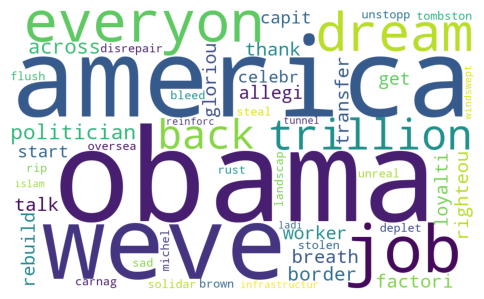

In [27]:
plt_wordcloud(cnt_all, '2017-Trump', 50)

In the Trump's speech in 2017, "Obama" is significant, as Trump mentioned the previous president, Obama, whose presidency ran 8 years in total.

## EOF